## Metis Spring 2015 Data Science Bootcamp: Project Luther, Heart Disease Data
1. Read data into a Pandas dataframe, make some plots, and prepare data for classifiers.
2. Make some clean plots for the blog.
3. Apply logistic regression:
  * with scikit-learn;
  * with statsmodels.
  * Find out which feature correlations cause the age coefficient to be negative.
  * Make some correlation plots between the features age, thalach, and ca.
  * Repeat fit on a subset of features (age and thalach, separately for ca=0 and ca>0)
  * Which features should we keep?
    - Find the set of features that yields the best accuracy score, using cross-validation.
    - Try eliminating features with a non-significant coefficient, one by one, while keeping the model deviance as low as possible.  We'll use this second method for the final results.
  * Compute logistic regression model accuracy, precision and recall for the final selection of features and using the full training data set (biased estimation).
  * Recompute accuracy, precision and recall using cross-validation to avoid bias.
3. Apply Gaussian Naive Bayes, optimize on accuracy.
4. Apply Support Vector Classifier, optimize on accuracy.
5. Apply Decision Tree Classifier, optimize on accuracy.
6. Apply Random Forest Classifier, optimize on accuracy.

### Read in the data, store into a dataframe, and convert categorical variables

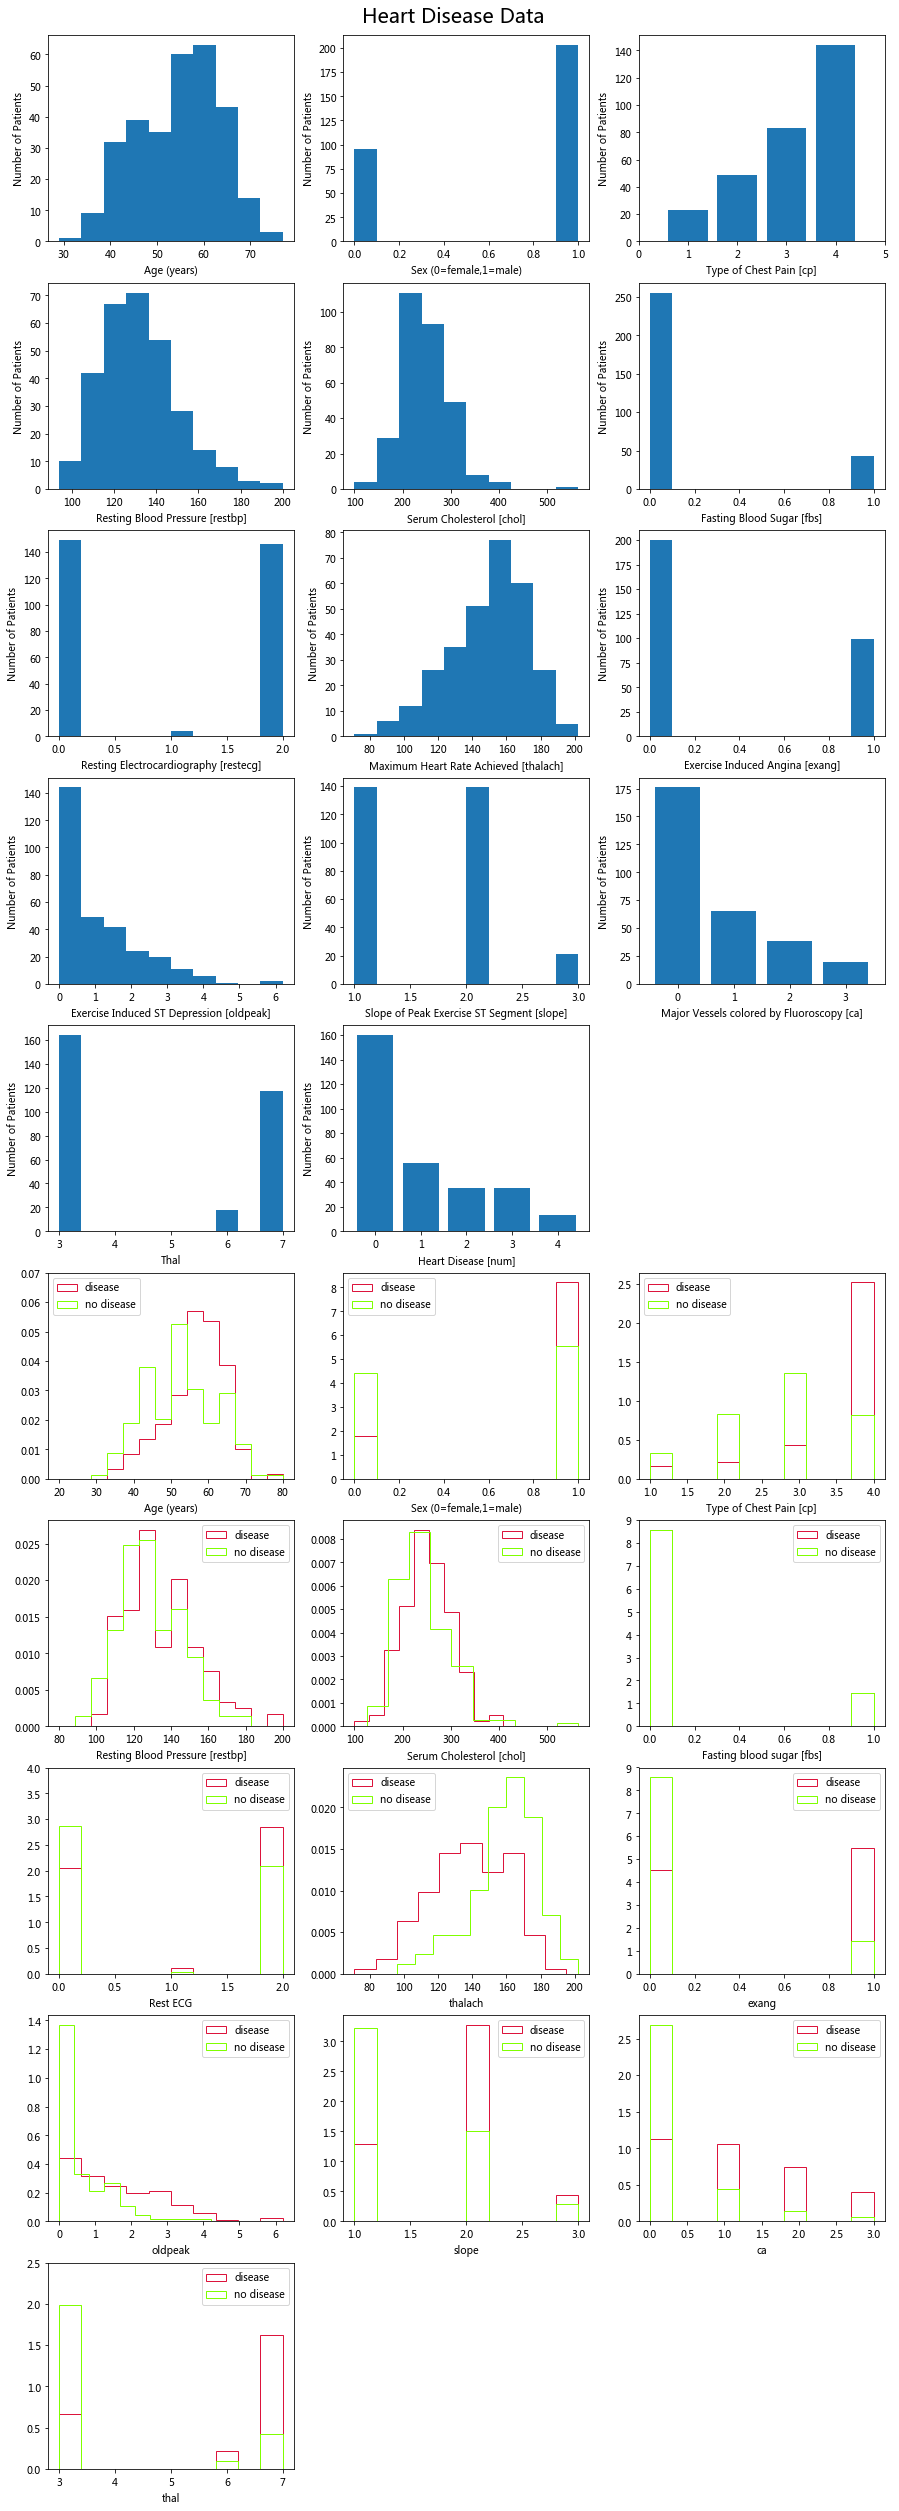

Intrinsic discrepancies between disease and no-disease, in decreasing order: 
   0.609044  (thal)
   0.584354  (cp)
   0.478634  (ca)
   0.456496  (thalach)
   0.420033  (oldpeak)
   0.352659  (exang)
   0.312049  (slope)
   0.198552  (age)
   0.156002  (sex)
   0.058716  (restecg)
   0.033252  (restbp)
   0.030527  (chol)
   0.000000  (fbs)

Number of patients in dataframe: 299, with disease: 139, without disease: 160

    age  sex  restbp   chol  fbs  thalach  exang  oldpeak   ca   hd  cp_1  \
0  63.0  1.0   145.0  233.0  1.0    150.0    0.0      2.3  0.0  0.0     1   
1  67.0  1.0   160.0  286.0  0.0    108.0    1.0      1.5  3.0  1.0     0   
2  67.0  1.0   120.0  229.0  0.0    129.0    1.0      2.6  2.0  1.0     0   
3  37.0  1.0   130.0  250.0  0.0    187.0    0.0      3.5  0.0  0.0     0   
4  41.0  0.0   130.0  204.0  0.0    172.0    0.0      1.4  0.0  0.0     0   

   cp_2  cp_3  recg_1  recg_2  slope_1  slope_3  thal_6  thal_7  
0     0     0       0       1        0        1

In [2]:
'''
List of available variables:

 1. age: continuous
 2. sex: categorical, 2 values {0: female, 1: male}
 3. cp (chest pain type): categorical, 4 values
    {1: typical angina, 2: atypical angina, 3: non-angina, 4: asymptomatic angina}
 4. restbp (resting blood pressure on admission to hospital): continuous (mmHg)
 5. chol (serum cholesterol level): continuous (mg/dl)
 6. fbs (fasting blood sugar): categorical, 2 values {0: <= 120 mg/dl, 1: > 120 mg/dl}
 7. restecg (resting electrocardiography): categorical, 3 values
    {0: normal, 1: ST-T wave abnormality, 2: left ventricular hypertrophy}
 8. thalach (maximum heart rate achieved): continuous
 9. exang (exercise induced angina): categorical, 2 values {0: no, 1: yes}
10. oldpeak (ST depression induced by exercise relative to rest): continuous
11. slope (slope of peak exercise ST segment): categorical, 3 values 
    {1: upsloping, 2: flat, 3: downsloping}
12. ca (number of major vessels colored by fluoroscopy): discrete (0,1,2,3)
13. thal: categorical, 3 values {3: normal, 6: fixed defect, 7: reversible defect}
14. num (diagnosis of heart disease): categorical, 5 values 
    {0: less than 50% narrowing in any major vessel, 
    1-4: more than 50% narrowing in 1-4 vessels}
    
The actual number of feature variables (after converting categorical variables
to dummy ones) is: 
1 (age) + 1 (sex) + 3 (cp) + 1 (restbp) + 1 (chol) + 1 (fbs) + 2 (restecg) + 
1 (thalach) + 1 (exang) + 1 (oldpeak) + 2 (slope) + 1 (ca) + 2 (thal) = 18

The response variable (num) is categorical with 5 values, but we don't have
enough data to predict all the categories. Therefore we'll replace num with:
14. hd (heart disease): categorical, 2 values {0: no, 1: yes}
'''
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pprint import pprint

# Given two histograms x and y (with the same range and binning), the following function
# calculates the intrinsic discrepancy (a symmetrized Kullback-Leibler distance) between them.
def intrinsic_discrepancy(x,y):
    assert len(x)==len(y)
    sumx = sum(xval for xval in x)
    sumy = sum(yval for yval in y)
    id1  = 0.0
    id2  = 0.0
    for (xval,yval) in zip(x,y):
        if (xval>0) and (yval>0):
            id1 += (float(xval)/sumx) * np.log((float(xval)/sumx)/(float(yval)/sumy))
            id2 += (float(yval)/sumy) * np.log((float(yval)/sumy)/(float(xval)/sumx))
    return min(id1,id2)

# Create Pandas dataframe.
columns = ["age", "sex", "cp", "restbp", "chol", "fbs", "restecg", 
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
df0     = pd.read_table("data/heart_disease_all14.csv", sep=',', header=None, names=columns)

# Make some plots to check the data
fig, axes = plt.subplots( nrows=10, ncols=3, figsize=(15,40) )
plt.subplots_adjust( wspace=0.20, hspace=0.20, top=0.97 )
plt.suptitle("Heart Disease Data", fontsize=20)
axes[0,0].hist(df0.age)
axes[0,0].set_xlabel("Age (years)")
axes[0,0].set_ylabel("Number of Patients")
axes[0,1].hist(df0.sex)
axes[0,1].set_xlabel("Sex (0=female,1=male)")
axes[0,1].set_ylabel("Number of Patients")
axes[0,2].hist(df0.cp,bins=4,range=(0.5,4.5),rwidth=0.80)
axes[0,2].set_xlim(0.0,5.0)
axes[0,2].set_xlabel("Type of Chest Pain [cp]")
axes[0,2].set_ylabel("Number of Patients")
axes[1,0].hist(df0.restbp)
axes[1,0].set_xlabel("Resting Blood Pressure [restbp]")
axes[1,0].set_ylabel("Number of Patients")
axes[1,1].hist(df0.chol)
axes[1,1].set_xlabel("Serum Cholesterol [chol]")
axes[1,1].set_ylabel("Number of Patients")
axes[1,2].hist(df0.fbs)
axes[1,2].set_xlabel("Fasting Blood Sugar [fbs]")
axes[1,2].set_ylabel("Number of Patients")
axes[2,0].hist(df0.restecg)
axes[2,0].set_xlabel("Resting Electrocardiography [restecg]")
axes[2,0].set_ylabel("Number of Patients")
axes[2,1].hist(df0.thalach)
axes[2,1].set_xlabel("Maximum Heart Rate Achieved [thalach]")
axes[2,1].set_ylabel("Number of Patients")
axes[2,2].hist(df0.exang)
axes[2,2].set_xlabel("Exercise Induced Angina [exang]")
axes[2,2].set_ylabel("Number of Patients")
axes[3,0].hist(df0.oldpeak)
axes[3,0].set_xlabel("Exercise Induced ST Depression [oldpeak]")
axes[3,0].set_ylabel("Number of Patients")
axes[3,1].hist(df0.slope)
axes[3,1].set_xlabel("Slope of Peak Exercise ST Segment [slope]")
axes[3,1].set_ylabel("Number of Patients")
axes[3,2].hist(df0.ca,bins=4,range=(-0.5,3.5),rwidth=0.8)
axes[3,2].set_xlim(-0.7,3.7)
axes[3,2].set_xlabel("Major Vessels colored by Fluoroscopy [ca]")
axes[3,2].set_ylabel("Number of Patients")
axes[4,0].hist(df0.thal)
axes[4,0].set_xlabel("Thal")
axes[4,0].set_ylabel("Number of Patients")
axes[4,1].hist(df0.num,bins=5,range=(-0.5,4.5),rwidth=0.8)
axes[4,1].set_xlim(-0.7,4.7)
axes[4,1].set_xlabel("Heart Disease [num]")
axes[4,1].set_ylabel("Number of Patients")
axes[4,2].axis("off")

# Marginal feature distributions compared for disease and no-disease (likelihoods)
bins = np.linspace(20, 80, 15)
axes[5,0].hist(df0[df0.num>0].age.tolist(),bins,color=["crimson"],histtype="step",label="disease",normed=True)
axes[5,0].hist(df0[df0.num==0].age,bins,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[5,0].set_xlabel("Age (years)")
axes[5,0].set_ylim(0.0,0.070)
axes[5,0].legend(prop={'size': 10},loc="upper left")
axes[5,1].hist(df0[df0.num>0].sex.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[5,1].hist(df0[df0.num==0].sex,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[5,1].set_xlabel("Sex (0=female,1=male)")
axes[5,1].legend(prop={'size': 10},loc="upper left")
axes[5,2].hist(df0[df0.num>0].cp.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[5,2].hist(df0[df0.num==0].cp,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[5,2].set_xlabel("Type of Chest Pain [cp]")
axes[5,2].legend(prop={'size': 10},loc="upper left")
bins = np.linspace(80, 200, 15)
axes[6,0].hist(df0[df0.num>0].restbp.tolist(),bins,color=["crimson"],histtype="step",label="disease",normed=True)
axes[6,0].hist(df0[df0.num==0].restbp,bins,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[6,0].set_xlabel("Resting Blood Pressure [restbp]")
axes[6,0].legend(prop={'size': 10},loc="upper right")
axes[6,1].hist(df0[df0.num>0].chol.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[6,1].hist(df0[df0.num==0].chol,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[6,1].set_xlabel("Serum Cholesterol [chol]")
axes[6,1].legend(prop={'size': 10},loc="upper right")
axes[6,2].hist(df0[df0.num>0].fbs.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[6,2].hist(df0[df0.num==0].fbs,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[6,2].set_xlabel("Fasting blood sugar [fbs]")
axes[6,2].legend(prop={'size': 10},loc="upper right")
axes[7,0].hist(df0[df0.num>0].restecg.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[7,0].hist(df0[df0.num==0].restecg,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[7,0].set_xlabel("Rest ECG")
axes[7,0].set_ylim(0.0,4.0)
axes[7,0].legend(prop={'size': 10},loc="upper right")
axes[7,1].hist(df0[df0.num>0].thalach.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[7,1].hist(df0[df0.num==0].thalach,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[7,1].set_xlabel("thalach")
axes[7,1].legend(prop={'size': 10},loc="upper left")
axes[7,2].hist(df0[df0.num>0].exang.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[7,2].hist(df0[df0.num==0].exang,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[7,2].set_xlabel("exang")
axes[7,2].legend(prop={'size': 10},loc="upper right")
axes[8,0].hist(df0[df0.num>0].oldpeak.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[8,0].hist(df0[df0.num==0].oldpeak,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[8,0].set_xlabel("oldpeak")
axes[8,0].legend(prop={'size': 10},loc="upper right")
axes[8,1].hist(df0[df0.num>0].slope.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[8,1].hist(df0[df0.num==0].slope,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[8,1].set_xlabel("slope")
axes[8,1].legend(prop={'size': 10},loc="upper right")
axes[8,2].hist(df0[df0.num>0].ca.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[8,2].hist(df0[df0.num==0].ca,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[8,2].set_xlabel("ca")
axes[8,2].legend(prop={'size': 10},loc="upper right")
axes[9,0].hist(df0[df0.num>0].thal.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[9,0].hist(df0[df0.num==0].thal,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[9,0].set_xlabel("thal")
axes[9,0].set_ylim(0.0,2.5)
axes[9,0].legend(prop={'size': 10},loc="upper right")
axes[9,1].axis("off")
axes[9,2].axis("off")
plt.show()

# Compute intrinsic discrepancies between disease and no-disease feature distributions
int_discr = {}
hist,bin_edges   = np.histogram(df0.age,density=False)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].age,bins=bin_edges,density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].age,bins=bin_edges,density=False)
int_discr["age"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].sex,bins=(-0.5,0.5,1.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].sex,bins=(-0.5,0.5,1.5),density=False)
int_discr["sex"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].cp,bins=(0.5,1.5,2.5,3.5,4.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].cp,bins=(0.5,1.5,2.5,3.5,4.5),density=False)
int_discr["cp"] = intrinsic_discrepancy(hist1,hist2)
hist,bin_edges   = np.histogram(df0.restbp,density=False)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].restbp,bins=bin_edges,density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].restbp,bins=bin_edges,density=False)
int_discr["restbp"] = intrinsic_discrepancy(hist1,hist2)
hist,bin_edges   = np.histogram(df0.chol,density=False)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].chol,bins=bin_edges,density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].chol,bins=bin_edges,density=False)
int_discr["chol"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].fbs,bins=(-0.5,0.5,1.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].fbs,bins=(-0.5,0.5,1.5),density=False)
int_discr["fbs"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].restecg,bins=(-0.5,0.5,1.5,2.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].restecg,bins=(-0.5,0.5,1.5,2.5),density=False)
int_discr["restecg"] = intrinsic_discrepancy(hist1,hist2)
hist,bin_edges   = np.histogram(df0.thalach,density=False)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].thalach,bins=bin_edges,density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].thalach,bins=bin_edges,density=False)
int_discr["thalach"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].exang,bins=(-0.5,0.5,1.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].exang,bins=(-0.5,0.5,1.5),density=False)
int_discr["exang"] = intrinsic_discrepancy(hist1,hist2)
hist,bin_edges   = np.histogram(df0.oldpeak,density=False)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].oldpeak,bins=bin_edges,density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].oldpeak,bins=bin_edges,density=False)
int_discr["oldpeak"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].slope,bins=(0.5,1.5,2.5,3.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].slope,bins=(0.5,1.5,2.5,3.5),density=False)
int_discr["slope"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].ca,bins=(-0.5,0.5,1.5,2.5,3.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].ca,bins=(-0.5,0.5,1.5,2.5,3.5),density=False)
int_discr["ca"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].thal,bins=(2.5,3.5,6.5,7.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].thal,bins=(2.5,3.5,6.5,7.5),density=False)
int_discr["thal"] = intrinsic_discrepancy(hist1,hist2)
id_list = Counter(int_discr).most_common()
print( 'Intrinsic discrepancies between disease and no-disease, in decreasing order: ')
for item in id_list:
    print ('   %f  (%s)' % (item[1],item[0]))
# Convert categorical variables with more than two values into dummy variables.
# Note that variable ca is discrete but not categorical, so we don't convert it.
df      = df0.copy()
dummies = pd.get_dummies(df["cp"],prefix="cp")
df      = df.join(dummies)
del df["cp"]
del df["cp_4.0"]
df      = df.rename(columns = {"cp_1.0":"cp_1","cp_2.0":"cp_2","cp_3.0":"cp_3"})

dummies = pd.get_dummies(df["restecg"],prefix="recg")
df      = df.join(dummies)
del df["restecg"]
del df["recg_0.0"]
df      = df.rename(columns = {"recg_1.0":"recg_1","recg_2.0":"recg_2"})

dummies = pd.get_dummies(df["slope"],prefix="slope")
df      = df.join(dummies)
del df["slope"]
del df["slope_2.0"]
df      = df.rename(columns = {"slope_1.0":"slope_1","slope_3.0":"slope_3"})

dummies = pd.get_dummies(df["thal"],prefix="thal")
df      = df.join(dummies)
del df["thal"]
del df["thal_3.0"]
df      = df.rename(columns = {"thal_6.0":"thal_6","thal_7.0":"thal_7"})

# Replace response variable values and rename
df["num"].replace(to_replace=[1,2,3,4],value=1,inplace=True)
df      = df.rename(columns = {"num":"hd"})

# New list of column labels after the above operations
new_columns_1 = ["age", "sex", "restbp", "chol", "fbs", "thalach", 
                 "exang", "oldpeak", "ca", "hd", "cp_1", "cp_2",
                 "cp_3", "recg_1", "recg_2", "slope_1", "slope_3",
                 "thal_6", "thal_7"]

print ('\nNumber of patients in dataframe: %i, with disease: %i, without disease: %i\n' \
      % (len(df.index),len(df[df.hd==1].index),len(df[df.hd==0].index)))
print (df.head())
print (df.describe())

# Standardize the dataframe
stdcols = ["age","restbp","chol","thalach","oldpeak"]
nrmcols = ["ca"]
stddf   = df.copy()
stddf[stdcols] = stddf[stdcols].apply(lambda x: (x-x.mean())/x.std())
stddf[nrmcols] = stddf[nrmcols].apply(lambda x: (x-x.mean())/(x.max()-x.min()))

new_columns_2 = new_columns_1[:9] + new_columns_1[10:]
new_columns_2.insert(0,new_columns_1[9])
stddf = stddf.reindex(columns=new_columns_2)

# Convert dataframe into lists for use by classifiers
yall = stddf["hd"]
Xall = stddf[new_columns_2[1:]].values

In [3]:
stddf

,hd,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1,cp_2,cp_3,recg_1,recg_2,slope_1,slope_3,thal_6,thal_7
0,0.0,0.938872,1.0,0.748505,-0.262427,1.0,0.029075,0.0,1.067685,-0.224080,1,0,0,0,1,0,1,1,0
1,1.0,1.381827,1.0,1.593683,0.746471,0.0,-1.787451,1.0,0.379672,0.775920,0,0,0,0,1,0,0,0,0
2,1.0,1.381827,1.0,-0.660124,-0.338570,0.0,-0.879188,1.0,1.325690,0.442586,0,0,0,0,1,0,0,0,1
3,0.0,-1.940335,1.0,-0.096672,0.061182,0.0,1.629347,0.0,2.099704,-0.224080,0,0,1,0,0,0,1,0,0
4,0.0,-1.497380,0.0,-0.096672,-0.814465,0.0,0.980588,0.0,0.293671,-0.224080,0,1,0,0,1,1,0,0,0
5,0.0,0.163701,1.0,-0.660124,-0.205319,0.0,1.240092,0.0,-0.222339,-0.224080,0,1,0,0,0,1,0,0,0
6,1.0,0.828133,0.0,0.466779,0.403826,0.0,0.461581,0.0,2.185706,0.442586,0,0,0,0,1,0,1,0,0
7,0.0,0.274439,0.0,-0.660124,2.040906,0.0,0.591333,1.0,-0.394342,-0.224080,0,0,0,0,0,1,0,0,0
8,1.0,0.938872,1.0,-0.096672,0.137325,0.0,-0.100677,0.0,0.293671,0.109253,0,0,0,0,1,0,0,0,1
9,1.0,-0.168515,1.0,0.466779,-0.833501,1.0,0.245328,1.0,1.755698,-0.224080,0,0,0,0,1,0,1,0,1


In [4]:
df

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,hd,cp_1,cp_2,cp_3,recg_1,recg_2,slope_1,slope_3,thal_6,thal_7
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,0.0,1,0,0,0,1,0,1,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,1.0,0,0,0,0,1,0,0,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,1.0,0,0,0,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0.0,0,0,1,0,0,0,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0.0,0,1,0,0,1,1,0,0,0
5,56.0,1.0,120.0,236.0,0.0,178.0,0.0,0.8,0.0,0.0,0,1,0,0,0,1,0,0,0
6,62.0,0.0,140.0,268.0,0.0,160.0,0.0,3.6,2.0,1.0,0,0,0,0,1,0,1,0,0
7,57.0,0.0,120.0,354.0,0.0,163.0,1.0,0.6,0.0,0.0,0,0,0,0,0,1,0,0,0
8,63.0,1.0,130.0,254.0,0.0,147.0,0.0,1.4,1.0,1.0,0,0,0,0,1,0,0,0,1
9,53.0,1.0,140.0,203.0,1.0,155.0,1.0,3.1,0.0,1.0,0,0,0,0,1,0,1,0,1


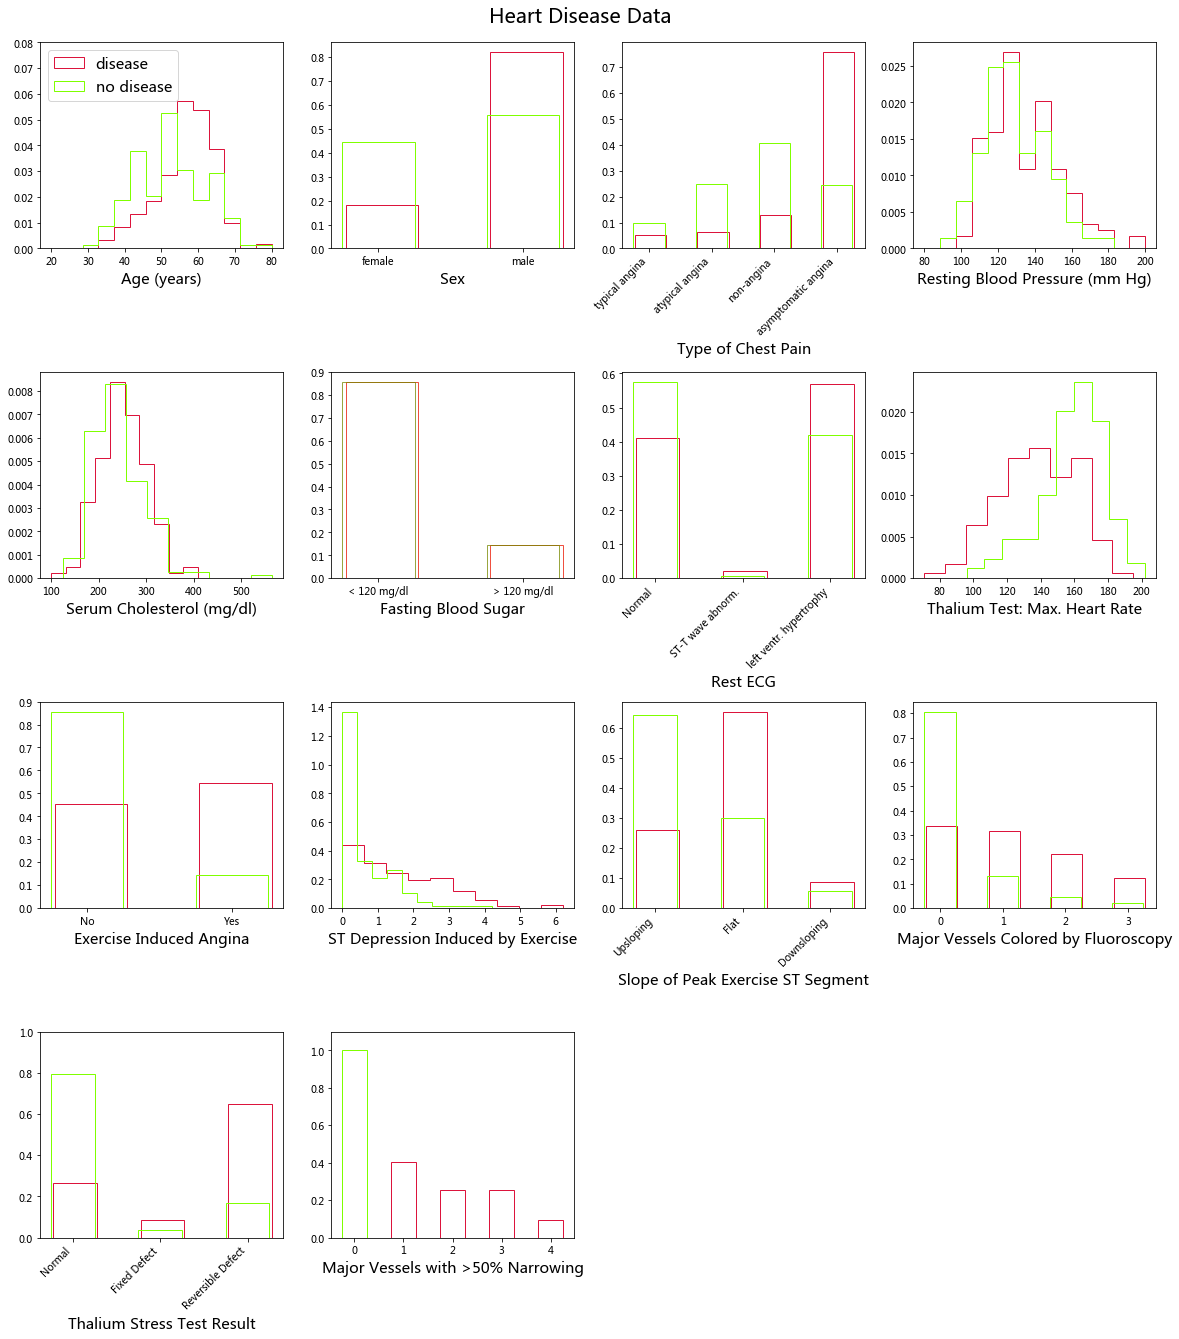

In [5]:
'''
Select some clean plots for the blog.
'''
fig, axes = plt.subplots( nrows=4, ncols=4, figsize=(20,20) )
plt.subplots_adjust( wspace=0.20, hspace=0.60, top=0.955)
plt.suptitle("Heart Disease Data", fontsize=20)

bins = np.linspace(20, 80, 15)
axes[0,0].hist(df0[df0.num>0].age.tolist(),bins,color=["crimson"],histtype="step",label="disease",normed=True)
axes[0,0].hist(df0[df0.num==0].age,bins,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[0,0].set_xlabel("Age (years)",fontsize=15)
axes[0,0].set_ylim(0.0,0.080)
axes[0,0].legend(prop={'size': 15},loc="upper left")

bins     = np.arange(2)
width    = 0.5
heights1 = df0[df0.num>0]["sex"].groupby(df0["sex"]).count()
heights2 = df0[df0.num==0]["sex"].groupby(df0["sex"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[0,1].bar(bins+0.025,heights1,width,align="center",edgecolor=["crimson"],color=["none"],label="disease")
axes[0,1].bar(bins,heights2,width,align="center",edgecolor=["chartreuse"],color=["none"],label="no disease")
axes[0,1].set_xlabel("Sex",fontsize=15)
axes[0,1].set_xticks(bins)
axes[0,1].set_xticklabels(["female","male"],ha="center")

bins     = np.arange(4)
width    = 0.5
heights1 = df0[df0.num>0]["cp"].groupby(df0["cp"]).count()
heights2 = df0[df0.num==0]["cp"].groupby(df0["cp"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[0,2].bar(bins+0.025,heights1,width,align="center",edgecolor=["crimson"],color=["none"],label="disease")
axes[0,2].bar(bins,heights2,width,align="center",edgecolor=["chartreuse"],color=["none"],label="no disease")
axes[0,2].set_xlabel("Type of Chest Pain",fontsize=15)
axes[0,2].set_xticks(bins)
axes[0,2].set_xticklabels(["typical angina", "atypical angina", "non-angina", "asymptomatic angina"],
                          ha="right",rotation=45.)

bins = np.linspace(80, 200, 15)
axes[0,3].hist(df0[df0.num>0].restbp.tolist(),bins,color=["crimson"],histtype="step",label="disease",normed=True)
axes[0,3].hist(df0[df0.num==0].restbp,bins,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[0,3].set_xlabel("Resting Blood Pressure (mm Hg)",fontsize=15)

axes[1,0].hist(df0[df0.num>0].chol.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[1,0].hist(df0[df0.num==0].chol,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[1,0].set_xlabel("Serum Cholesterol (mg/dl)",fontsize=15)

bins     = np.arange(2)
width    = 0.5
heights1 = df0[df0.num>0]["fbs"].groupby(df0["fbs"]).count()
heights2 = df0[df0.num==0]["fbs"].groupby(df0["fbs"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[1,1].bar(bins+0.025,heights1,width,align="center",edgecolor=(0.917,0.083,0,0.75),color=["none"],label="disease")
axes[1,1].bar(bins,heights2,width,align="center",edgecolor=(0.467,0.533,0,0.75),color=["none"],label="no disease")
axes[1,1].set_xlabel("Fasting Blood Sugar",fontsize=15)
axes[1,1].set_xticks(bins)
axes[1,1].set_xticklabels(["< 120 mg/dl","> 120 mg/dl"],ha="center")

bins     = np.arange(3)
width    = 0.5
heights1 = df0[df0.num>0]["restecg"].groupby(df0["restecg"]).count()
heights2 = df0[df0.num==0]["restecg"].groupby(df0["restecg"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[1,2].bar(bins+0.025,heights1,width,align="center",edgecolor=["crimson"],color=["none"],label="disease")
axes[1,2].bar(bins,heights2,width,align="center",edgecolor=["chartreuse"],color=["none"],label="no disease")
axes[1,2].set_xlabel("Rest ECG",fontsize=15)
axes[1,2].set_xticks(bins)
axes[1,2].set_xticklabels(["Normal","ST-T wave abnorm.","left ventr. hypertrophy"],ha="right",rotation=45.)

axes[1,3].hist(df0[df0.num>0].thalach.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[1,3].hist(df0[df0.num==0].thalach,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[1,3].set_xlabel("Thalium Test: Max. Heart Rate",fontsize=15)

bins     = np.arange(2)
width    = 0.5
heights1 = df0[df0.num>0]["exang"].groupby(df0["exang"]).count()
heights2 = df0[df0.num==0]["exang"].groupby(df0["exang"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[2,0].bar(bins+0.025,heights1,width,align="center",edgecolor=["crimson"],color=["none"],label="disease")
axes[2,0].bar(bins,heights2,width,align="center",edgecolor=["chartreuse"],color=["none"],label="no disease")
axes[2,0].set_xlabel("Exercise Induced Angina",fontsize=15)
axes[2,0].set_xticks(bins)
axes[2,0].set_xticklabels(["No","Yes"],ha="center")

axes[2,1].hist(df0[df0.num>0].oldpeak.tolist(),color=["crimson"],histtype="step",label="disease",normed=True)
axes[2,1].hist(df0[df0.num==0].oldpeak,color=["chartreuse"],histtype="step",label="no disease",normed=True)
axes[2,1].set_xlabel("ST Depression Induced by Exercise", fontsize=15)

bins     = np.arange(3)
width    = 0.5
heights1 = df0[df0.num>0]["slope"].groupby(df0["slope"]).count()
heights2 = df0[df0.num==0]["slope"].groupby(df0["slope"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[2,2].bar(bins+0.025,heights1,width,align="center",edgecolor=["crimson"],color=["none"],label="disease")
axes[2,2].bar(bins,heights2,width,align="center",edgecolor=["chartreuse"],color=["none"],label="no disease")
axes[2,2].set_xlabel("Slope of Peak Exercise ST Segment",fontsize=15)
axes[2,2].set_xticks(bins)
axes[2,2].set_xticklabels(["Upsloping","Flat","Downsloping"],ha="right",rotation=45.)

bins     = np.arange(4)
width    = 0.5
heights1 = df0[df0.num>0]["ca"].groupby(df0["ca"]).count()
heights2 = df0[df0.num==0]["ca"].groupby(df0["ca"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[2,3].bar(bins+0.025,heights1,width,align="center",edgecolor=["crimson"],color=["none"],label="disease")
axes[2,3].bar(bins,heights2,width,align="center",edgecolor=["chartreuse"],color=["none"],label="no disease")
axes[2,3].set_xlabel("Major Vessels Colored by Fluoroscopy",fontsize=15)
axes[2,3].set_xticks(bins)
axes[2,3].set_xticklabels(["0","1","2","3"],ha="center")

bins     = np.arange(3)
width    = 0.5
heights1 = df0[df0.num>0]["thal"].groupby(df0["thal"]).count()
heights2 = df0[df0.num==0]["thal"].groupby(df0["thal"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[3,0].bar(bins+0.025,heights1,width,align="center",edgecolor=["crimson"],color=["none"],label="disease")
axes[3,0].bar(bins,heights2,width,align="center",edgecolor=["chartreuse"],color=["none"],label="no disease")
axes[3,0].set_xlabel("Thalium Stress Test Result",fontsize=15)
axes[3,0].set_xticks(bins)
axes[3,0].set_xticklabels(["Normal","Fixed Defect","Reversible Defect"],ha="right",rotation=45.)
axes[3,0].set_ylim(0.0,1.0)

bins     = np.arange(5)
width    = 0.5
heights1 = np.array(list(map(float,[0]+df0[df0.num>0]["num"].groupby(df0["num"]).count().tolist())))
heights2 = np.array(list(map(float,df0[df0.num==0]["num"].groupby(df0["num"]).count().tolist()+[0,0,0,0])))
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[3,1].bar(bins,heights1,width,align="center",edgecolor=["crimson"],color=["none"],label="disease")
axes[3,1].bar(bins,heights2,width,align="center",edgecolor=["chartreuse"],color=["none"],label="no disease")
axes[3,1].set_xlabel("Major Vessels with >50% Narrowing",fontsize=15)
axes[3,1].set_xticks(bins)
axes[3,1].set_xticklabels(["0","1","2","3","4"],ha="center")
axes[3,1].set_ylim(0.0,1.1)

axes[3,2].axis("off")
axes[3,3].axis("off")

plt.show()
#fig.savefig("mcnulty_fig1.png")

### Logistic Regression

In [6]:
'''
Note about logistic regression with scikit-learn and with statsmodels:
* In scikit-learn we can specify penalty="l1" or penalty="l2", with
  an associated C=c, which is the *inverse* of the regularization strength.
  Thus, for zero regularization specify a high value of c.  Scikit-learn
  does not calculate uncertainties on the fit coefficients.
* In statsmodels we can specify method="l1" and an associated regularization
  strength alpha.  There is no method="l2", but no-regularization can be
  obtained by setting alpha=0.  Statsmodels does compute uncertainties on
  the fit coefficients.
In the following couple of cells we do a fit to the heart-disease data
with all features included, first with scikit-learn, then with statsmodels.
Let's make sure we understand what we are doing by obtaining the same results
with both software packages.
'''
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

lasso = False

nfeatures = len(stddf.columns)
if lasso:           # lasso regularization
    penalty = "l1"
    cval    = 1.0
    alpha   = [1.0]*nfeatures
else:               # no regularization
    penalty = "l1"
    cval    = 1000.0
    alpha   = 0.0

model = LogisticRegression(fit_intercept=True,penalty=penalty,dual=False,C=cval)
print(model)
lrfit = model.fit(Xall,yall)
print(('\nLogisticRegression score on full data set: %f\n' % lrfit.score(Xall,yall)))
ypred = model.predict(Xall)
print('\nClassification report on full data set:')
print((metrics.classification_report(yall,ypred)))
print('\nConfusion matrix:')
print((metrics.confusion_matrix(yall,ypred)))
print('\nLogisticRegression coefficients:')
coeff = model.coef_.tolist()[0]
for index in range(len(coeff)):
    print(('%s : %8.5f' % (new_columns_2[index+1].rjust(9),coeff[index])))
print(('Intercept : %f' %model.intercept_))

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression score on full data set: 0.872910


Classification report on full data set:
             precision    recall  f1-score   support

        0.0       0.86      0.91      0.88       160
        1.0       0.89      0.83      0.86       139

avg / total       0.87      0.87      0.87       299


Confusion matrix:
[[146  14]
 [ 24 115]]

LogisticRegression coefficients:
      age : -0.12376
      sex :  1.54777
   restbp :  0.43320
     chol :  0.22064
      fbs : -0.59459
  thalach : -0.41716
    exang :  0.71806
  oldpeak :  0.41982
       ca :  3.92905
     cp_1 : -2.10070
     cp_2 : -0.84577
     cp_3 : -1.85031
   recg_1 :  0.77470
   recg_2 :  0.46867
  slope_1 : -1.16436
  slope_3 : -0.64702
   thal_6 

In [7]:
'''
Now with statsmodels
'''
import pandas as pd
import statsmodels.api as sm

df1              = stddf.copy()
df1["intercept"] = 1.0

train_cols = df1[df1.columns[1:]]
response   = df1[df1.columns[0]]
model      = sm.Logit(response, train_cols, missing="raise")
 
# fit the model
print(('\nNumber of features in model: %i' %nfeatures))
print(('Lasso = %s' % lasso))
if lasso: print(('alpha=%s' %alpha))
print(" ")

if lasso:
    result = model.fit_regularized(method=penalty, alpha=alpha, disp=1)
else:
    result = model.fit(method="newton", maxiter=100, disp=1)

print((result.summary()))

G:\Program Files\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



Number of features in model: 19
Lasso = False
 
Optimization terminated successfully.
         Current function value: 0.321016
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                     hd   No. Observations:                  299
Model:                          Logit   Df Residuals:                      280
Method:                           MLE   Df Model:                           18
Date:                Sun, 15 Jul 2018   Pseudo R-squ.:                  0.5352
Time:                        16:50:55   Log-Likelihood:                -95.984
converged:                       True   LL-Null:                       -206.51
                                        LLR p-value:                 5.920e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.1238      0.223     -0.554      0.579     

In [8]:
'''
The previous two cells demonstrate that we can obtain the same results
with scikit-learn and statsmodels.  However, the results show a problem:
the fit coefficient of the "age" feature is negative, indicating that 
the risk of heart disease might decrease with age!  This must be the 
result of a correlation effect, because when we fit age alone the coefficient
is positive (see also the plot of the marginal distributions of age at the
beginning).  To see where the correlation comes from, we are going to repeat
the fit by adding one feature at a time to the age feature, until the sign
of the age fit coefficient flips from + to -.
'''
import pandas as pd
import statsmodels.api as sm
import itertools

print(('\nNumber of Features = %i, Lasso = %s\n' %(nfeatures,lasso)))
iterable   = list(range(2,nfeatures))
for s in range(len(iterable)+1,0,-1):
    for comb in itertools.combinations(iterable, s):
        dropped_columns  = list(comb)
        df1              = stddf.copy()
        df1              = df1.drop(df1.columns[dropped_columns],axis=1) 
#        df1["intercept"] = 1.0
        train_cols       = df1[df1.columns[1:]]
        response         = df1[df1.columns[0]]
        model            = sm.Logit(response, train_cols)
        if lasso:
            result = model.fit_regularized(method=penalty, alpha=alpha, disp=0)
        else:
            result = model.fit(method="newton", maxiter=100, disp=0)
        print(('With the columns %s, "age" coefficient = %f +/- %f' \
        % (list(df1.columns[1:].values),result.params[0],result.bse[0])))
        if result.params[0] < 0.0:
            break
    else:
        continue
    break


Number of Features = 19, Lasso = False

With the columns ['age'], "age" coefficient = 0.465889 +/- 0.123370
With the columns ['age', 'thal_7'], "age" coefficient = 0.445439 +/- 0.127149
With the columns ['age', 'thal_6'], "age" coefficient = 0.458219 +/- 0.123435
With the columns ['age', 'slope_3'], "age" coefficient = 0.464302 +/- 0.123360
With the columns ['age', 'slope_1'], "age" coefficient = 0.429446 +/- 0.130818
With the columns ['age', 'recg_2'], "age" coefficient = 0.458366 +/- 0.123785
With the columns ['age', 'recg_1'], "age" coefficient = 0.460071 +/- 0.123772
With the columns ['age', 'cp_3'], "age" coefficient = 0.490671 +/- 0.130007
With the columns ['age', 'cp_2'], "age" coefficient = 0.421323 +/- 0.127308
With the columns ['age', 'cp_1'], "age" coefficient = 0.487567 +/- 0.125792
With the columns ['age', 'ca'], "age" coefficient = 0.142862 +/- 0.140091
With the columns ['age', 'oldpeak'], "age" coefficient = 0.340596 +/- 0.133474
With the columns ['age', 'exang'], "age"

##### Conclusions:

* Fitting age alone gives a positive coefficient, as expected.
* It takes at least two additional features to cause the age coefficient to turn negative (for example "thalach" and "ca").  However the negative age coefficient is not significantly different from 0.

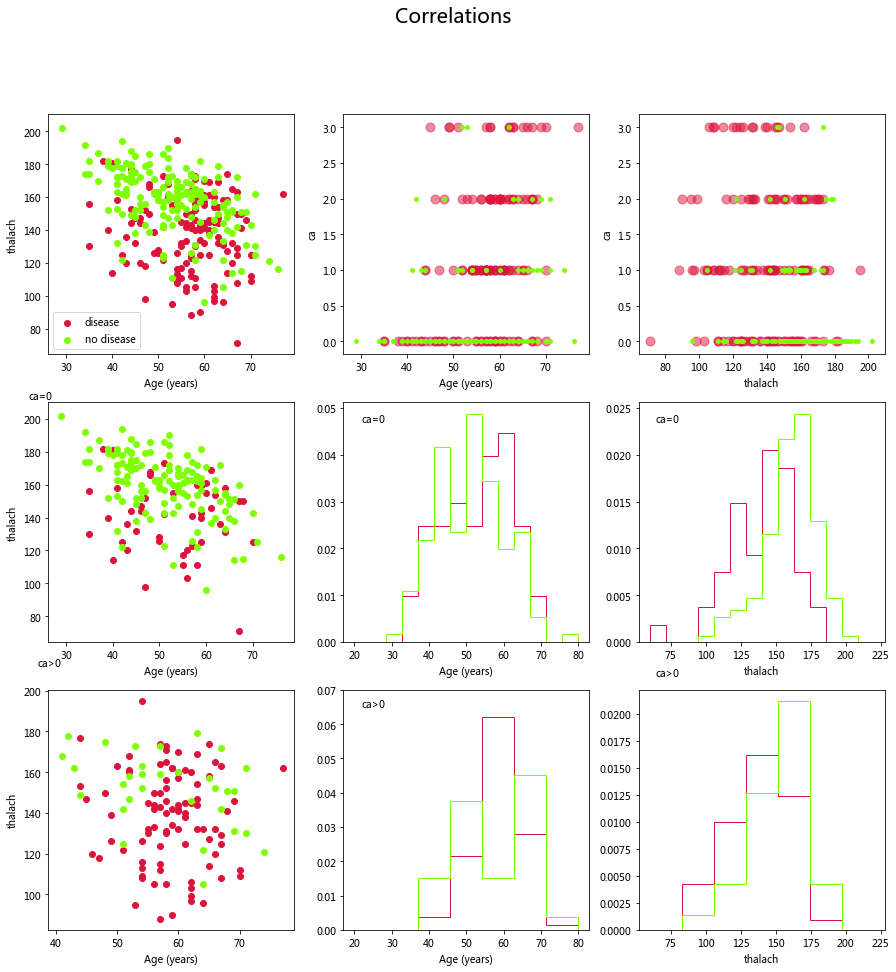

In [9]:
'''
Make correlation plots for the features age, thalach, and ca.
'''
import numpy as np

fig, axes = plt.subplots( nrows=3, ncols=3, figsize=(15,15) )
plt.suptitle("Correlations", fontsize=20)
axes[0,0].scatter(df[df.hd==1].age,df[df.hd==1].thalach,color=["crimson"],label="disease")
axes[0,0].scatter(df[df.hd==0].age,df[df.hd==0].thalach,color=["chartreuse"],label="no disease")
axes[0,0].set_xlabel("Age (years)")
axes[0,0].set_ylabel("thalach")
axes[0,0].legend(prop={'size': 10},loc="lower left")
axes[0,1].scatter(df[df.hd==1].age,df[df.hd==1].ca,color=["crimson"],s=80,alpha=0.5,label="disease")
axes[0,1].scatter(df[df.hd==0].age,df[df.hd==0].ca,color=["chartreuse"],s=15,label="no disease")
axes[0,1].set_xlabel("Age (years)")
axes[0,1].set_ylabel("ca")
axes[0,2].scatter(df[df.hd==1].thalach,df[df.hd==1].ca,color=["crimson"],s=80,alpha=0.5,label="disease")
axes[0,2].scatter(df[df.hd==0].thalach,df[df.hd==0].ca,color=["chartreuse"],s=15,label="no disease")
axes[0,2].set_xlabel("thalach")
axes[0,2].set_ylabel("ca")
axes[1,0].scatter(df[(df.hd==1)&(df.ca==0)].age,df[(df.hd==1)&(df.ca==0)].thalach,\
                  color=["crimson"],label="disease")
axes[1,0].scatter(df[(df.hd==0)&(df.ca==0)].age,df[(df.hd==0)&(df.ca==0)].thalach,\
                  color=["chartreuse"],label="no disease")
axes[1,0].text(22.0,212.0,"ca=0")
axes[1,0].set_xlabel("Age (years)")
axes[1,0].set_ylabel("thalach")
bins = np.linspace(20, 80, 15)
axes[1,1].hist(df[(df.hd==1)&(df.ca==0)].age.tolist(),bins,color=["crimson"],\
               histtype="step",normed=True,label="disease")
axes[1,1].hist(df[(df.hd==0)&(df.ca==0)].age.tolist(),bins,color=["chartreuse"],\
               histtype="step",normed=True,label="no disease")
axes[1,1].text(22.0,0.047,"ca=0")
axes[1,1].set_xlabel("Age (years)")
bins = np.linspace(60, 220, 15)
axes[1,2].hist(df[(df.hd==1)&(df.ca==0)].thalach.tolist(),bins,color=["crimson"],\
               histtype="step",normed=True,label="disease")
axes[1,2].hist(df[(df.hd==0)&(df.ca==0)].thalach.tolist(),bins,color=["chartreuse"],\
               histtype="step",normed=True,label="no disease")
axes[1,2].text(64.0,0.0235,"ca=0")
axes[1,2].set_xlabel("thalach")
axes[2,0].scatter(df[(df.hd==1)&(df.ca>0)].age,df[(df.hd==1)&(df.ca>0)].thalach,\
                  color=["crimson"],label="disease")
axes[2,0].scatter(df[(df.hd==0)&(df.ca>0)].age,df[(df.hd==0)&(df.ca>0)].thalach,\
                  color=["chartreuse"],label="no disease")
axes[2,0].text(37.0,212.0,"ca>0")
axes[2,0].set_xlabel("Age (years)")
axes[2,0].set_ylabel("thalach")
bins = np.linspace(20, 80, 8)
axes[2,1].hist(df[(df.hd==1)&(df.ca>0)].age.tolist(),bins,color=["crimson"],\
               histtype="step",normed=True,label="disease")
axes[2,1].hist(df[(df.hd==0)&(df.ca>0)].age.tolist(),bins,color=["chartreuse"],\
               histtype="step",normed=True,label="no disease")
axes[2,1].text(22.0,0.065,"ca>0")
axes[2,1].set_xlabel("Age (years)")
axes[2,1].set_ylim(0.0,0.07)
bins = np.linspace(60, 220, 8)
axes[2,2].hist(df[(df.hd==1)&(df.ca>0)].thalach.tolist(),bins,color=["crimson"],\
               histtype="step",normed=True,label="disease")
axes[2,2].hist(df[(df.hd==0)&(df.ca>0)].thalach.tolist(),bins,color=["chartreuse"],\
               histtype="step",normed=True,label="no disease")
axes[2,2].text(64.0,0.0235,"ca>0")
axes[2,2].set_xlabel("thalach")
plt.show()

In [10]:
'''
Fit using only the age and thalach features, separately for ca=0 and ca>0.
'''
import pandas as pd
import statsmodels.api as sm

dropped_columns  = [2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18] # Drop all features except 1 (age) and 6 (thalach).

# Fit for ca=0 first (ca<0 is equivalent):
df1        = stddf.copy()
df1        = df1[df1.ca<0]
df1        = df1.drop(df1.columns[dropped_columns],axis=1) 

In [11]:
df1

,hd,age,thalach
0,0.0,0.938872,0.029075
3,0.0,-1.940335,1.629347
4,0.0,-1.497380,0.980588
5,0.0,0.163701,1.240092
7,0.0,0.274439,0.591333
9,1.0,-0.168515,0.245328
10,0.0,0.274439,-0.057426
11,0.0,0.163701,0.158827
13,0.0,-1.165164,1.023839
14,0.0,-0.279254,0.548082


In [12]:
stddf

,hd,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1,cp_2,cp_3,recg_1,recg_2,slope_1,slope_3,thal_6,thal_7
0,0.0,0.938872,1.0,0.748505,-0.262427,1.0,0.029075,0.0,1.067685,-0.224080,1,0,0,0,1,0,1,1,0
1,1.0,1.381827,1.0,1.593683,0.746471,0.0,-1.787451,1.0,0.379672,0.775920,0,0,0,0,1,0,0,0,0
2,1.0,1.381827,1.0,-0.660124,-0.338570,0.0,-0.879188,1.0,1.325690,0.442586,0,0,0,0,1,0,0,0,1
3,0.0,-1.940335,1.0,-0.096672,0.061182,0.0,1.629347,0.0,2.099704,-0.224080,0,0,1,0,0,0,1,0,0
4,0.0,-1.497380,0.0,-0.096672,-0.814465,0.0,0.980588,0.0,0.293671,-0.224080,0,1,0,0,1,1,0,0,0
5,0.0,0.163701,1.0,-0.660124,-0.205319,0.0,1.240092,0.0,-0.222339,-0.224080,0,1,0,0,0,1,0,0,0
6,1.0,0.828133,0.0,0.466779,0.403826,0.0,0.461581,0.0,2.185706,0.442586,0,0,0,0,1,0,1,0,0
7,0.0,0.274439,0.0,-0.660124,2.040906,0.0,0.591333,1.0,-0.394342,-0.224080,0,0,0,0,0,1,0,0,0
8,1.0,0.938872,1.0,-0.096672,0.137325,0.0,-0.100677,0.0,0.293671,0.109253,0,0,0,0,1,0,0,0,1
9,1.0,-0.168515,1.0,0.466779,-0.833501,1.0,0.245328,1.0,1.755698,-0.224080,0,0,0,0,1,0,1,0,1


In [11]:

train_cols = df1[df1.columns[1:]]
response   = df1[df1.columns[0]]
model      = sm.Logit(response, train_cols)
if lasso:
    result = model.fit_regularized(method=penalty, alpha=alpha, disp=0)
else:
    result = model.fit(method="newton", maxiter=100, disp=0)
print(('\nFit results with ca<0 and Lasso = %s\n' %lasso))
print((result.summary()))

# Now fit for ca>0:
df1        = stddf.copy()
df1        = df1[df1.ca>0]
df1        = df1.drop(df1.columns[dropped_columns],axis=1) 
train_cols = df1[df1.columns[1:]]
response   = df1[df1.columns[0]]
model      = sm.Logit(response, train_cols)
if lasso:
    result = model.fit_regularized(method=penalty, alpha=alpha, disp=0)
else:
    result = model.fit(method="newton", maxiter=100, disp=0)
print(('\nFit results with ca>0 and Lasso = %s\n' %lasso))
print((result.summary()))


Fit results with ca<0 and Lasso = False

                           Logit Regression Results                           
Dep. Variable:                     hd   No. Observations:                  176
Model:                          Logit   Df Residuals:                      174
Method:                           MLE   Df Model:                            1
Date:                Sun, 15 Jul 2018   Pseudo R-squ.:                 0.01383
Time:                        10:49:58   Log-Likelihood:                -100.72
converged:                       True   LL-Null:                       -102.13
                                        LLR p-value:                   0.09284
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0393      0.182     -0.216      0.829      -0.396       0.318
thalach       -1.2219      0.233     -5.242      0.000      -1.679      -0.765

Fit resul

##### Conclusions:
* For ca=0 the age coefficient is negative but not significant.
* For ca>0 the age coefficient is positive and almost significant.
* In both cases the thalach coefficient is negative and significant.

In [13]:
'''
Select features to keep: Method 1
Optimize logistic regression on accuracy score, using cross-validation.
Here we use sklearn since it includes a cross_validation method.
'''
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
import itertools
from pprint import pprint

best_score = []
best_std   = []
best_comb  = []
nfeatures  = 18
iterable   = list(range(nfeatures))
for intercept in [True,False]:
    model  = LogisticRegression(fit_intercept=intercept,penalty=penalty,dual=False,C=cval)
    for s in range(len(iterable)+1):
        for comb in itertools.combinations(iterable, s):
            if len(comb) > 0:
                Xsel = []
                for patient in Xall:
                    Xsel.append([patient[ind] for ind in comb])
                this_scores = cross_val_score(model, Xsel, y=yall, cv=3 )
                score_mean  = np.mean(this_scores)
                score_std   = np.std(this_scores)
                comb1       = list(comb)
                if intercept: comb1.append(nfeatures)
                if len(best_score) > 0: 
                    if score_mean > best_score[0]:
                        best_score = []
                        best_std   = []
                        best_comb  = []
                        best_score.append(score_mean)
                        best_std.append(score_std)
                        best_comb.append(comb1)
                    elif score_mean == best_score[0]:
                        best_score.append(score_mean)
                        best_std.append(score_std)
                        best_comb.append(comb1)
                else:
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb1)

new_columns_3 = new_columns_2[1:]
new_columns_3.append("intercept")
num_ties = len(best_score)
for ind in range(num_ties):
    comb1 = best_comb[ind][:]
    if nfeatures in comb1:
        intercept = True
        comb1.remove(nfeatures)
    else:
        intercept = False
    model = LogisticRegression(fit_intercept=intercept,penalty=penalty,dual=False,C=cval)
    Xsel  = []
    for patient in Xall:
        Xsel.append([patient[i] for i in comb1])
    lrfit = model.fit(Xsel,yall)
    print(('\nResults for combination %s:' %best_comb[ind]))
    print(('LogisticRegression score on full data set:      %f' % lrfit.score(Xsel,yall)))
    print(('LogisticRegression score from cross-validation: %f +/- %f' % (best_score[ind],best_std[ind])))
    print('LogisticRegression coefficients:')
    coeff = model.coef_.tolist()[0]
    if intercept: coeff.append(model.intercept_)
    for jnd in range(len(coeff)):
        print(('%s : %8.5f' % (new_columns_3[best_comb[ind][jnd]].rjust(9),coeff[jnd])))


Results for combination [0, 1, 2, 5, 7, 8, 9, 10, 11, 14, 16, 17]:
LogisticRegression score on full data set:      0.859532
LogisticRegression score from cross-validation: 0.876288 +/- 0.016870
LogisticRegression coefficients:
      age : -0.09652
      sex :  1.37064
   restbp :  0.44654
  thalach : -0.47083
  oldpeak :  0.42531
       ca :  3.79981
     cp_1 : -2.34290
     cp_2 : -1.10925
     cp_3 : -2.13850
  slope_1 : -1.18764
   thal_6 : -0.25441
   thal_7 :  1.44928

Results for combination [0, 1, 2, 5, 7, 8, 9, 10, 11, 12, 14, 16, 17]:
LogisticRegression score on full data set:      0.859532
LogisticRegression score from cross-validation: 0.876288 +/- 0.016870
LogisticRegression coefficients:
      age : -0.09779
      sex :  1.37508
   restbp :  0.44229
  thalach : -0.46265
  oldpeak :  0.41795
       ca :  3.80981
     cp_1 : -2.34065
     cp_2 : -1.11468
     cp_3 : -2.14544
   recg_1 :  0.51089
  slope_1 : -1.19612
   thal_6 : -0.24959
   thal_7 :  1.44820


##### 年龄相关系数仍为负

In [ ]:
'''
Select features to keep: Method 2
Eliminate features with non-significant coefficients one-by-one, while keeping the model 
deviance as low as possible.  A coefficient is deemed significant if its fitted z-score 
is above 2.0.
'''
import pandas as pd
import numpy as np
import statsmodels.api as sm

def select_features(df0,**kwargs):
    """Selects features for a logistic regression model. Starts by including all features, and then
    eliminates non-significant features one-by-one, in such a way as to minimize the increase in 
    deviance after each elimination."""
    if "verbose" in kwargs: 
        vb = kwargs["verbose"]
    else:
        vb = 0
    if "method" in kwargs:
        md = kwargs["method"]
    else:
        md = "newton"
    feature_names   = list(df0.columns)      # Get data frame column names, these are the features to be fitted.
    feature_names.append("intercept")        # Add an intercept feature.
    nfeatures       = len(feature_names) - 1 # First feature is response variable, so doesn't count.
    saved_columns   = list(range(1,nfeatures+1))
    dropped_columns = []
    while len(saved_columns)>1:
        df1              = df0.copy()
        df1["intercept"] = 1.0
        df1              = df1.drop(df1.columns[dropped_columns],axis=1)
        features         = df1[df1.columns[1:]]
        response         = df1[df1.columns[0]]
        model            = sm.Logit(response, features, missing="raise")
        result           = model.fit(method=md, maxiter=100, disp=0)
        if len(saved_columns)==nfeatures:
            if vb >= 1:
                print(('\nInitial -log(L)=%8.5f; fit method = %s\n' %(-result.llf,md)))
        if all(np.abs(tval) >= 2.0 for tval in result.tvalues):
            if vb >= 1:
                print(('\nFinal selection includes %i features:\n' % len(saved_columns)))
                print((result.summary()))
            break
        else:
            llfmin = 999999.0
            colmin = -100
            for col in saved_columns:
                dropped_columns.append(col)
                df1              = df0.copy()
                df1["intercept"] = 1.0
                df1              = df1.drop(df1.columns[dropped_columns],axis=1)
                features         = df1[df1.columns[1:]]
                response         = df1[df1.columns[0]]
                model            = sm.Logit(response, features, missing="raise")
                result           = model.fit(method=md, maxiter=100, disp=0)
                if -result.llf < llfmin:
                    llfmin = -result.llf
                    colmin = col
                dropped_columns.remove(col)
            if vb >= 2:
                print(('Dropping %s, -log(L)=%8.5f...' % (feature_names[colmin].rjust(9),llfmin)))
            saved_columns.remove(colmin)
            dropped_columns.append(colmin)
    else:
        if vb >= 1:
            print('Final selection has no features left')
    return result,saved_columns

select_features(stddf,verbose=2,method="newton")

In [ ]:
'''
Print out some features of the optimal logistic regression model
for the full data set (accuracy, precision, recall,...)
'''
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

model = LogisticRegression(fit_intercept=False,penalty="l1",dual=False,C=1000.0)
comb = [1,2,5,8,9,10,11,14,17]
print(comb)
Xsel  = []
for patient in Xall:
    Xsel.append([patient[ind] for ind in comb])
print(model)
lrfit = model.fit(Xsel,yall)
print(('\nLogisticRegression score on full data set: %f\n' % lrfit.score(Xsel,yall)))
ypred = model.predict(Xsel)
print('\nClassification report on full data set:')
print((metrics.classification_report(yall,ypred)))
print('\nConfusion matrix:')
print((metrics.confusion_matrix(yall,ypred)))
log_reg_coef = model.coef_[0]
log_reg_intc = model.intercept_
print(('\nLogisticRegression coefficients: %s' %log_reg_coef))
print(('LogisticRegression intercept: %f' %log_reg_intc))

# Separate disease from no-disease cases for a histogram of logistic regression probabilities:
Xsel0 = [patient for (patient,status) in zip(Xsel,yall) if status==0] # No-disease cases
Xsel1 = [patient for (patient,status) in zip(Xsel,yall) if status==1] # Disease cases
print(('\nNumber of disease cases: %i, no-disease cases: %i' %(len(Xsel1),len(Xsel0))))
Xsel0_Prob = [p1 for (p0,p1) in model.predict_proba(Xsel0)] # Predicted prob. of heart disease for no-disease cases
Xsel1_Prob = [p1 for (p0,p1) in model.predict_proba(Xsel1)] # Predicted prob. of heart disease for disease cases

# Here we do a little test to make sure we understand how the logistic regression coefficients work:
qsum = 0.0
for patient,prob in zip(Xsel0,Xsel0_Prob):
    lrprob = 1.0/(1.0+np.exp(-sum(patient[i]*log_reg_coef[i] for i in range(9))-log_reg_intc))
    qsum  += (lrprob-prob)**2
for patient,prob in zip(Xsel1,Xsel1_Prob):
    lrprob = 1.0/(1.0+np.exp(-sum(patient[i]*log_reg_coef[i] for i in range(9))-log_reg_intc))
    qsum  += (lrprob-prob)**2
print(('Sum of quadratic differences between probability calculations: %f' %qsum)) # Should be zero!

# Here is the plot:
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )
plt.subplots_adjust( top=0.92 )
plt.suptitle("Cleveland Data Set", fontsize=20)
axes.hist(Xsel0_Prob,color=["chartreuse"],histtype="step",label="no-disease cases (160)")
axes.hist(Xsel1_Prob,color=["crimson"],histtype="step",label="disease cases (139)")
axes.set_xlabel("Predicted Probability of Disease",fontsize=15)
axes.set_ylabel("Number of Patients",fontsize=15)
axes.set_ylim( 0.0, 90.0 )
axes.legend(prop={'size': 15},loc="upper right")
plt.show()
#fig.savefig('LogRegProbabilities.png', dpi=200)

In [ ]:
'''
Get unbiased estimates of accuracy, precision and recall by doing cross-validation 
on a three-way partition of the original data set.  The cross-validation includes
both the feature selection procedure and the logistic regression fit.
'''
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm

# Make a list of the feature names
feature_names = list(stddf.columns)
feature_names.append("intercept")

# Split standardized Cleveland data set into three (approximately) equal test sets dfp1c, dfp2c, dfp3c.
# Then arrange for dfp1, dfp2 and dfp3 to be the complements of dfp1c, dfp2c and dfp3c respectively.
dfp1,  dfp1c = train_test_split( stddf, test_size=0.33, random_state=1 ) # dfp1 is 2/3, dfp1c is 1/3 of stddf
dfp2c, dfp3c = train_test_split( dfp1,  test_size=0.50, random_state=1 ) # dfp2c, dfp3c are both 1/3 of stddf
dfp2 = pd.concat([dfp1c,dfp3c])
dfp3 = pd.concat([dfp1c,dfp2c])

# Save the response variable from the test data frames.
dfp1c_true   = list(dfp1c.hd)
dfp2c_true   = list(dfp2c.hd)
dfp3c_true   = list(dfp3c.hd)

# For each training set, find the optimal set of features.
result1,sel1 = select_features(dfp1,verbose=0,method="lbfgs")
result2,sel2 = select_features(dfp2,verbose=0,method="lbfgs")
result3,sel3 = select_features(dfp3,verbose=0,method="lbfgs")

print(('Partition 1 features: %s' %[feature_names[ind] for ind in sel1]))
print(('Partition 2 features: %s' %[feature_names[ind] for ind in sel2]))
print(('Partition 3 features: %s' %[feature_names[ind] for ind in sel3]))

# Drop the non-selected columns from the test data frames.  This is different for 1, 2 and 3.
nfeatures = len(stddf.columns)
drop1     = [icol for icol in range(nfeatures) if icol not in sel1]
drop2     = [icol for icol in range(nfeatures) if icol not in sel2]
drop3     = [icol for icol in range(nfeatures) if icol not in sel3]
dfp1c     = dfp1c.drop(dfp1c.columns[drop1],axis=1)
dfp2c     = dfp2c.drop(dfp2c.columns[drop2],axis=1)
dfp3c     = dfp3c.drop(dfp3c.columns[drop3],axis=1)

# Intercept is not part of the original dataframes, so it needs to be added explicitly if selected.
if 19 in sel1: dfp1c["intercept"] = 1.0
if 19 in sel2: dfp2c["intercept"] = 1.0
if 19 in sel3: dfp3c["intercept"] = 1.0
    
# Compute the predictions for the test data sets.
hd1_pred  = result1.predict(dfp1c,linear=False)
hd2_pred  = result2.predict(dfp2c,linear=False)
hd3_pred  = result3.predict(dfp3c,linear=False)

hd1_all   = list(zip(dfp1c_true,hd1_pred))
hd2_all   = list(zip(dfp2c_true,hd2_pred))
hd3_all   = list(zip(dfp3c_true,hd3_pred))

# Compute the confusion matrices.
nparts = 3
yy = list(range(nparts))
yn = list(range(nparts))
nn = list(range(nparts))
ny = list(range(nparts))
for ind,hd_all in enumerate([hd1_all,hd2_all,hd3_all]):
    yy[ind] = sum([1 for [tr,pr] in hd_all if tr==1 and pr>=0.5])
    yn[ind] = sum([1 for [tr,pr] in hd_all if tr==1 and pr<0.5])
    nn[ind] = sum([1 for [tr,pr] in hd_all if tr==0 and pr<0.5])
    ny[ind] = sum([1 for [tr,pr] in hd_all if tr==0 and pr>=0.5])
    
# Compute accuracy, precision, recall
acc = list(range(nparts))
pr1 = list(range(nparts))
pr2 = list(range(nparts))
rl1 = list(range(nparts))
rl2 = list(range(nparts))
for ind in range(3):
    acc[ind] = float(yy[ind]+nn[ind])/(yy[ind]+yn[ind]+ny[ind]+nn[ind]) # fraction of predictions that are correct
    pr1[ind] = float(yy[ind])/(yy[ind]+ny[ind])            # fraction of disease predictions that are correct
    pr2[ind] = float(nn[ind])/(nn[ind]+yn[ind])            # fraction of no-disease predictions that are correct
    rl1[ind] = float(yy[ind])/(yy[ind]+yn[ind])            # fraction of disease cases that are identified
    rl2[ind] = float(nn[ind])/(nn[ind]+ny[ind])            # fraction of no-disease cases that are identified

# Compute averages and standard deviations
acc_mean = np.mean(acc)
acc_err  = np.std(acc,ddof=1)/np.sqrt(nparts)
pr1_mean = np.mean(pr1)
pr1_err  = np.std(pr1,ddof=1)/np.sqrt(nparts)
pr2_mean = np.mean(pr2)
pr2_err  = np.std(pr2,ddof=1)/np.sqrt(nparts)
rl1_mean = np.mean(rl1)
rl1_err  = np.std(rl1,ddof=1)/np.sqrt(nparts)
rl2_mean = np.mean(rl2)
rl2_err  = np.std(rl2,ddof=1)/np.sqrt(nparts)

# Print out results
print(' ')
print(('Accuracy:                [%5.3f, %5.3f, %5.3f]; average= %5.3f +/- %5.3f' 
      %(acc[0],acc[1],acc[2],acc_mean,acc_err)))
print(('Precision on disease:    [%5.3f, %5.3f, %5.3f]; average= %5.3f +/- %5.3f' 
      %(pr1[0],pr1[1],pr1[2],pr1_mean,pr1_err)))
print(('Precision on no-disease: [%5.3f, %5.3f, %5.3f]; average= %5.3f +/- %5.3f' 
      %(pr2[0],pr2[1],pr2[2],pr2_mean,pr2_err)))
print(('Recall on disease:       [%5.3f, %5.3f, %5.3f]; average= %5.3f +/- %5.3f' 
      %(rl1[0],rl1[1],rl1[2],rl1_mean,rl1_err)))
print(('Recall on no-disease:    [%5.3f, %5.3f, %5.3f]; average= %5.3f +/- %5.3f' 
      %(rl2[0],rl2[1],rl2[2],rl2_mean,rl2_err)))

### Gaussian Naive Bayes

In [14]:
'''
Optimize Gaussian Naive Bayes
'''
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
import itertools
from pprint import pprint

best_score = []
best_std   = []
best_comb  = []
nfeatures  = 18
iterable   = list(range(nfeatures))
gnb        = GaussianNB()
for s in range(len(iterable)+1):
    for comb in itertools.combinations(iterable, s):
        if len(comb) > 0:
            Xsel = []
            for patient in Xall:
                Xsel.append([patient[ind] for ind in comb])
            this_scores = cross_val_score(gnb, Xsel, y=yall, cv=3 )
            score_mean  = np.mean(this_scores)
            score_std   = np.std(this_scores)
            if len(best_score) > 0: 
                if score_mean > best_score[0]:
                    best_score = []
                    best_std   = []
                    best_comb  = []
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
                elif score_mean == best_score[0]:
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
            else:
                best_score.append(score_mean)
                best_std.append(score_std)
                best_comb.append(comb)
num_ties = len(best_score)
for ind in range(num_ties):
    print(('For comb=%s, Gaussian Naive Bayes Accuracy = %f +/- %f' \
            % (best_comb[ind],best_score[ind],best_std[ind])))
ypred = model.predict(Xall)
print('\nClassification report on full data set:')
print((metrics.classification_report(yall,ypred)))

G:\Program Files\Anaconda\lib\site-packages\sklearn\naive_bayes.py:428: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
G:\Program Files\Anaconda\lib\site-packages\sklearn\naive_bayes.py:430: RuntimeWarning: divide by zero encountered in true_divide
  (self.sigma_[i, :]), 1)
G:\Program Files\Anaconda\lib\site-packages\sklearn\naive_bayes.py:430: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)
G:\Program Files\Anaconda\lib\site-packages\sklearn\naive_bayes.py:430: RuntimeWarning: invalid value encountered in subtract
  (self.sigma_[i, :]), 1)


For comb=(0, 1, 3, 5, 6, 7, 8, 9, 11, 14, 17), Gaussian Naive Bayes Accuracy = 0.852985 +/- 0.015617


ValueError: X has 18 features per sample; expecting 13

### Support Vector Classifier

In [ ]:
'''
Optimize support vector classifier
'''
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
import itertools
from pprint import pprint

best_score = []
best_std   = []
best_comb  = []
nfeatures  = 18
iterable   = list(range(nfeatures))
model      = SVC()
for s in range(len(iterable)+1):
    for comb in itertools.combinations(iterable, s):
        if len(comb) > 0:
            Xsel = []
            for patient in Xall:
                Xsel.append([patient[ind] for ind in comb])
            this_scores = cross_val_score(model, Xsel, y=yall, cv=3 )
            score_mean  = np.mean(this_scores)
            score_std   = np.std(this_scores)
            if len(best_score) > 0: 
                if score_mean > best_score[0]:
                    best_score = []
                    best_std   = []
                    best_comb  = []
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
                elif score_mean == best_score[0]:
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
            else:
                best_score.append(score_mean)
                best_std.append(score_std)
                best_comb.append(comb)
num_ties = len(best_score)
for ind in range(num_ties):
    print(('For comb=%s, Support Vector Classifier Accuracy = %f +/- %f' \
            % (best_comb[ind],best_score[ind],best_std[ind])))

### Decision Tree Classifier

In [ ]:
'''
Optimize decision tree classifier
'''
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
import itertools
from pprint import pprint

best_score = []
best_std   = []
best_comb  = []
nfeatures  = 18
iterable   = list(range(nfeatures))
model      = DecisionTreeClassifier()
for s in range(len(iterable)+1):
    for comb in itertools.combinations(iterable, s):
        if len(comb) > 0:
            Xsel = []
            for patient in Xall:
                Xsel.append([patient[ind] for ind in comb])
            this_scores = cross_val_score(model, Xsel, y=yall, cv=3 )
            score_mean  = np.mean(this_scores)
            score_std   = np.std(this_scores)
            if len(best_score) > 0: 
                if score_mean > best_score[0]:
                    best_score = []
                    best_std   = []
                    best_comb  = []
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
                elif score_mean == best_score[0]:
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
            else:
                best_score.append(score_mean)
                best_std.append(score_std)
                best_comb.append(comb)
num_ties = len(best_score)
for ind in range(num_ties):
    print(('For comb=%s, Decision Tree Classifier Accuracy = %f +/- %f' \
            % (best_comb[ind],best_score[ind],best_std[ind])))

### Random Forest Classifier

In [ ]:
'''
Optimize random forest classifier
'''
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
import itertools
from pprint import pprint

best_score = []
best_std   = []
best_comb  = []
nfeatures  = 18
iterable   = list(range(nfeatures))
model      = RandomForestClassifier()
for s in range(len(iterable)+1):
    for comb in itertools.combinations(iterable, s):
        if len(comb) > 0:
            Xsel = []
            for patient in Xall:
                Xsel.append([patient[ind] for ind in comb])
            this_scores = cross_val_score(model, Xsel, y=yall, cv=3 )
            score_mean  = np.mean(this_scores)
            score_std   = np.std(this_scores)
            if len(best_score) > 0: 
                if score_mean > best_score[0]:
                    best_score = []
                    best_std   = []
                    best_comb  = []
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
                elif score_mean == best_score[0]:
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
            else:
                best_score.append(score_mean)
                best_std.append(score_std)
                best_comb.append(comb)
num_ties = len(best_score)
for ind in range(num_ties):
    print(('For comb=%s, Random Forest Classifier Accuracy = %f +/- %f' \
            % (best_comb[ind],best_score[ind],best_std[ind])))